In [66]:
import torch.distributions as dis
import torch
p = dis.Normal(loc=0, scale=1)
q = dis.Normal(loc=0.1, scale=0.2)
x = q.sample(sample_shape=(100_000,))
truekl = dis.kl_divergence(q, p)
print("true", truekl)
logr = p.log_prob(x) - q.log_prob(x)
k1 = -logr
k2 = logr ** 2 / 2
k3 = (logr.exp() - 1) - logr
k4 = torch.where(logr < 0, k3, torch.min(k1, k3))
r = torch.exp(logr)
clip_r = torch.clamp(r,max=6)
k3_clip = clip_r - 1 - logr
k3_clip_pos = torch.where(k3_clip < 0, 0, k3_clip)
for k in (k1, k2, k3, k3_clip, k3_clip_pos, k4):
    print((k.mean() - truekl) / truekl, k.std() / truekl)

true tensor(1.1344)
tensor(0.0012) tensor(0.5983)
tensor(-0.2283) tensor(0.5026)
tensor(-0.3313) tensor(6.2617)
tensor(-0.4842) tensor(0.2907)
tensor(-0.4841) tensor(0.2902)
tensor(-0.5709) tensor(0.4172)


# ROLL Batch数据查看工具

这个notebook用于查看和分析ROLL训练过程中dump出来的batch数据。

In [67]:
import pickle
import json
import os
import torch
import numpy as np
from typing import Dict, Any
from IPython.display import display, HTML

In [68]:
def load_batch_data(file_path: str):
    """加载pickle格式的batch数据"""
    print(f"正在加载batch数据: {file_path}")
    with open(file_path, 'rb') as f:
        batch = pickle.load(f)
    return batch

# 示例：加载batch数据
# batch = load_batch_data('/path/to/debug/batch-100.pkl')

In [69]:
def print_batch_info(batch):
    """打印batch的基本信息"""
    print("="*50)
    print("BATCH数据基本信息")
    print("="*50)
    
    # 基本信息
    print(f"Batch大小: {len(batch)}")
    print(f"Batch类型: {type(batch)}")
    
    # Tensor数据信息
    if batch.batch is not None:
        print(f"\nTensor数据 (batch.batch):")
        print(f"  TensorDict大小: {batch.batch.batch_size}")
        print(f"  Tensor键值: {list(batch.batch.keys())}")
        
        for key, tensor in batch.batch.items():
            print(f"    {key}: {tensor.shape}, dtype={tensor.dtype}, device={tensor.device}")
    
    # 非Tensor数据信息
    if batch.non_tensor_batch:
        print(f"\n非Tensor数据 (batch.non_tensor_batch):")
        for key, value in batch.non_tensor_batch.items():
            print(f"  {key}: {type(value)}, shape={value.shape if hasattr(value, 'shape') else 'N/A'}")
            if hasattr(value, 'dtype'):
                print(f"    dtype={value.dtype}")
    
    # 元信息
    if batch.meta_info:
        print(f"\n元信息 (batch.meta_info):")
        for key, value in batch.meta_info.items():
            print(f"  {key}: {value}")

def analyze_tensor_data(batch, sample_size=3):
    """分析tensor数据的详细内容"""
    print("="*50)
    print("TENSOR数据详细分析")
    print("="*50)
    
    if batch.batch is None:
        print("没有tensor数据")
        return
    
    for key, tensor in batch.batch.items():
        print(f"\n{key}:")
        print(f"  形状: {tensor.shape}")
        print(f"  数据类型: {tensor.dtype}")
        print(f"  设备: {tensor.device}")
        
        # 数值统计
        if tensor.dtype in [torch.float16, torch.float32, torch.float64]:
            print(f"  数值范围: [{tensor.min().item():.4f}, {tensor.max().item():.4f}]")
            print(f"  均值: {tensor.mean().item():.4f}")
            print(f"  标准差: {tensor.std().item():.4f}")
        
        # 显示样本数据
        print(f"  样本数据 (前{sample_size}个):")
        for i in range(min(sample_size, len(tensor))):
            sample = tensor[i]
            if sample.dim() == 1:
                print(f"    [{i}]: {sample[:10].tolist()}{'...' if len(sample) > 10 else ''}")
            else:
                print(f"    [{i}]: shape={sample.shape}")

def analyze_non_tensor_data(batch, sample_size=3):
    """分析非tensor数据的详细内容"""
    print("="*50)
    print("非TENSOR数据详细分析")
    print("="*50)
    
    if not batch.non_tensor_batch:
        print("没有非tensor数据")
        return
    
    for key, value in batch.non_tensor_batch.items():
        print(f"\n{key}:")
        print(f"  类型: {type(value)}")
        print(f"  长度: {len(value)}")
        
        if hasattr(value, 'shape'):
            print(f"  形状: {value.shape}")
        if hasattr(value, 'dtype'):
            print(f"  dtype: {value.dtype}")
        
        # 显示样本数据
        print(f"  样本数据 (前{sample_size}个):")
        for i in range(min(sample_size, len(value))):
            sample = value[i]
            if isinstance(sample, str):
                # 对于字符串，显示前100个字符
                display_sample = sample[:100] + "..." if len(sample) > 100 else sample
                print(f"    [{i}]: {repr(display_sample)}")
            elif isinstance(sample, (list, tuple)):
                # 对于列表/元组，显示前5个元素
                display_sample = str(sample[:5]) + "..." if len(sample) > 5 else str(sample)
                print(f"    [{i}]: {display_sample}")
            else:
                print(f"    [{i}]: {sample}")

In [70]:
def show_field_details(batch, field_name):
    """显示特定字段的详细信息"""
    print(f"\n=== 字段: {field_name} ===")
    
    # 检查tensor字段
    if batch.batch is not None and field_name in batch.batch:
        tensor = batch.batch[field_name]
        print(f"类型: Tensor")
        print(f"形状: {tensor.shape}")
        print(f"数据类型: {tensor.dtype}")
        print(f"设备: {tensor.device}")
        
        if tensor.dtype in [torch.float16, torch.float32, torch.float64]:
            print(f"数值范围: [{tensor.min().item():.4f}, {tensor.max().item():.4f}]")
            print(f"均值: {tensor.mean().item():.4f}")
            print(f"标准差: {tensor.std().item():.4f}")
        
        # 显示前几个样本
        print(f"\n前3个样本:")
        for i in range(min(3, len(tensor))):
            sample = tensor[i]
            if sample.dim() == 1:
                print(f"  [{i}]: {sample[:20].tolist()}{'...' if len(sample) > 20 else ''}")
            else:
                print(f"  [{i}]: shape={sample.shape}")
        
        # for i in range(len(tensor)):
        #     if tensor[i].min() < 0:
        #         break
        i = 31
        import matplotlib.pyplot as plt
        print(f"i: {i}")
        plt.plot(tensor[i].cpu().numpy())
        plt.show()
    
    # 检查非tensor字段
    elif field_name in batch.non_tensor_batch:
        value = batch.non_tensor_batch[field_name]
        print(f"类型: {type(value)}")
        print(f"长度: {len(value)}")
        
        if hasattr(value, 'shape'):
            print(f"形状: {value.shape}")
        if hasattr(value, 'dtype'):
            print(f"dtype: {value.dtype}")
        
        # 显示前几个样本
        print(f"\n前3个样本:")
        for i in range(min(3, len(value))):
            sample = value[i]
            if isinstance(sample, str):
                display_sample = sample[:100] + "..." if len(sample) > 100 else sample
                print(f"  [{i}]: {repr(display_sample)}")
            elif isinstance(sample, (list, tuple)):
                display_sample = str(sample[:5]) + "..." if len(sample) > 5 else str(sample)
                print(f"  [{i}]: {display_sample}")
            else:
                print(f"  [{i}]: {sample}")
    
    else:
        print(f"字段 '{field_name}' 不存在")

def show_sample(batch, idx):
    """显示特定样本的所有信息"""
    if idx >= len(batch):
        print(f"错误: 索引 {idx} 超出范围 (batch大小: {len(batch)})")
        return
    
    print(f"\n=== 样本 {idx} ===")
    
    # 显示tensor数据
    if batch.batch is not None:
        print("Tensor数据:")
        for key, tensor in batch.batch.items():
            sample = tensor[idx]
            if sample.dim() == 1:
                print(f"  {key}: {sample[:20].tolist()}{'...' if len(sample) > 20 else ''}")
            else:
                print(f"  {key}: shape={sample.shape}")
    
    # 显示非tensor数据
    if batch.non_tensor_batch:
        print("\n非Tensor数据:")
        for key, value in batch.non_tensor_batch.items():
            sample = value[idx]
            if isinstance(sample, str):
                display_sample = sample[:200] + "..." if len(sample) > 200 else sample
                print(f"  {key}: {repr(display_sample)}")
            else:
                print(f"  {key}: {sample}")

def show_stats(batch):
    """显示数值统计信息"""
    print("\n=== 数值统计信息 ===")
    
    if batch.batch is None:
        print("没有tensor数据")
        return
    
    for key, tensor in batch.batch.items():
        if tensor.dtype in [torch.float16, torch.float32, torch.float64]:
            print(f"\n{key}:")
            print(f"  形状: {tensor.shape}")
            print(f"  数值范围: [{tensor.min().item():.4f}, {tensor.max().item():.4f}]")
            print(f"  均值: {tensor.mean().item():.4f}")
            print(f"  标准差: {tensor.std().item():.4f}")
            print(f"  中位数: {tensor.median().item():.4f}")

## 使用示例

### 1. 加载batch数据
```python
# 替换为你的batch文件路径
batch_file = '/path/to/debug/batch-100.pkl'
batch = load_batch_data(batch_file)
```

### 2. 查看基本信息
```python
print_batch_info(batch)
```

### 3. 分析tensor数据
```python
analyze_tensor_data(batch)
```

### 4. 分析非tensor数据
```python
analyze_non_tensor_data(batch)
```

### 5. 查看特定字段
```python
show_field_details(batch, 'input_ids')
show_field_details(batch, 'scores')
show_field_details(batch, 'advantages')
```

### 6. 查看特定样本
```python
show_sample(batch, 0)  # 查看第一个样本
show_sample(batch, 5)  # 查看第六个样本
```

### 7. 查看统计信息
```python
show_stats(batch)
```

```

In [71]:
batch_file = './runs/tictactoe_selfplay/20250812-132326/debug/batch-0.pkl'
batch = load_batch_data(batch_file)
print_batch_info(batch)

正在加载batch数据: ./runs/tictactoe_selfplay/20250812-132326/debug/batch-0.pkl
BATCH数据基本信息
Batch大小: 128
Batch类型: <class 'roll.distributed.scheduler.protocol.DataProto'>

Tensor数据 (batch.batch):
  TensorDict大小: torch.Size([128])
  Tensor键值: ['input_ids', 'attention_mask', 'position_ids', 'penalty', 'llm_response_mask', 'non_prompt_mask', 'response_mask', 'prompt_mask', 'scores', 'values', 'value_sparse', 'entropy', 'ref_log_probs', 'old_log_probs', 'token_level_rewards', 'response_level_rewards', 'raw_advantages', 'advantages', 'returns']
    input_ids: torch.Size([128, 16384]), dtype=torch.int64, device=cpu
    attention_mask: torch.Size([128, 16384]), dtype=torch.int64, device=cpu
    position_ids: torch.Size([128, 16384]), dtype=torch.int64, device=cpu
    penalty: torch.Size([128]), dtype=torch.float32, device=cpu
    llm_response_mask: torch.Size([128, 16384]), dtype=torch.int64, device=cpu
    non_prompt_mask: torch.Size([128, 16384]), dtype=torch.int64, device=cpu
    response_mask: to


=== 字段: response_mask ===
类型: Tensor
形状: torch.Size([128, 16384])
数据类型: torch.int64
设备: cpu

前3个样本:
  [0]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
  [1]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
  [2]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
i: 31


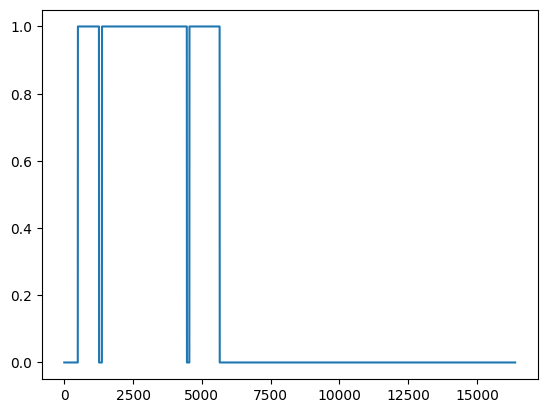


=== 字段: values ===
类型: Tensor
形状: torch.Size([128, 16383])
数据类型: torch.float32
设备: cpu
数值范围: [-1.0000, 1.0000]
均值: 0.0197
标准差: 0.1758

前3个样本:
  [0]: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
  [1]: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
  [2]: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
i: 31


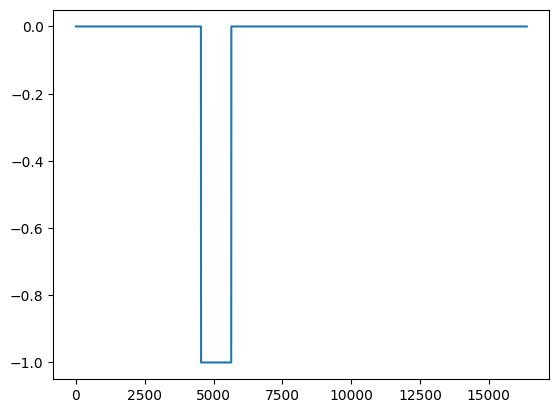


=== 字段: value_sparse ===
类型: Tensor
形状: torch.Size([128, 16384])
数据类型: torch.float32
设备: cpu
数值范围: [-1.0000, 1.0000]
均值: 0.0000
标准差: 0.0047

前3个样本:
  [0]: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
  [1]: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
  [2]: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
i: 31


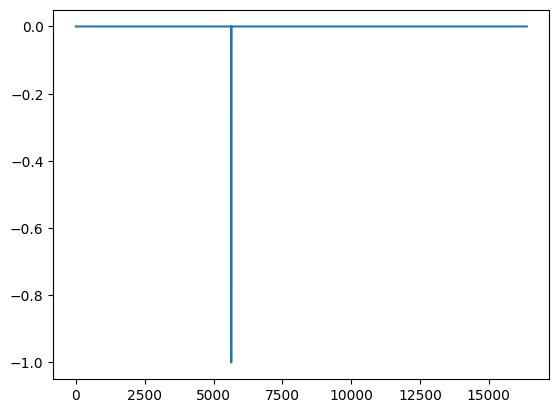

In [72]:
show_field_details(batch, 'response_mask')
show_field_details(batch, 'values')
show_field_details(batch, 'value_sparse')

## Batch数据结构说明

dump出来的数据是`DataProto`对象，包含以下三个主要部分：

### 1. `batch.batch` - Tensor数据 (TensorDict)
常见的tensor字段包括：
- `input_ids` - 输入token的ID序列
- `attention_mask` - 注意力掩码
- `scores` - 环境奖励分数
- `advantages` - 优势函数值
- `returns` - 回报值
- `values` - 价值函数值
- `log_probs` - 对数概率
- `ref_log_probs` - 参考模型的对数概率
- `old_log_probs` - 旧策略的对数概率
- `response_mask` - 响应掩码
- `prompt_mask` - 提示掩码
- `non_prompt_mask` - 非提示掩码

### 2. `batch.non_tensor_batch` - 非Tensor数据
包含非tensor类型的数据，通常是numpy数组：
- `env_ids` - 环境ID
- `group_ids` - 组ID
- `llm_input_texts` - LLM输入文本
- `messages_list` - 消息列表
- `tags` - 标签
- `frames` - 环境帧（如果启用渲染）
- `episode_scores` - 回合分数
- `llm_raw_text_list` - LLM原始文本列表

### 3. `batch.meta_info` - 元信息
包含batch的元数据信息：
- `global_step` - 全局步数
- `is_offload_states` - 是否卸载状态
- 其他训练相关的元信息